In [1]:
from visualizer import draw_dot
from head2grad import Value

In [2]:
v1 = Value(1, label='v1')
v2 = Value(2, label='v2')
v3 = v1 + v2; v3.label = 'v3'
v4 = Value(-5, label='v4')
v5 = v4 * v3; v5.label = 'v5'

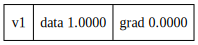

In [3]:
draw_dot(v1)

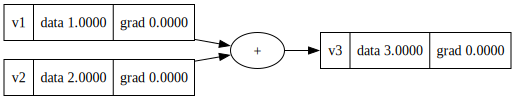

In [4]:
draw_dot(v3)

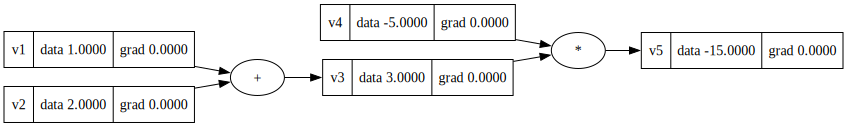

In [5]:
draw_dot(v5)

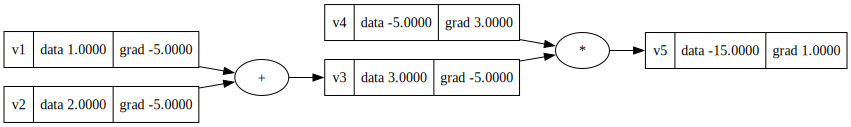

In [6]:
v5.backward()
draw_dot(v5)

### Tanh and topological

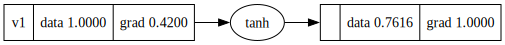

In [7]:
v1 = Value(1, label='v1')
v2 = v1.tanh()
v2.backward()
draw_dot(v2)

In [8]:
from head2grad import build_topological

build_topological(v5, [])

[Value(data=-15), Value(data=3), Value(data=2), Value(data=1), Value(data=-5)]

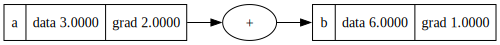

In [9]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

### Testing

tanh func

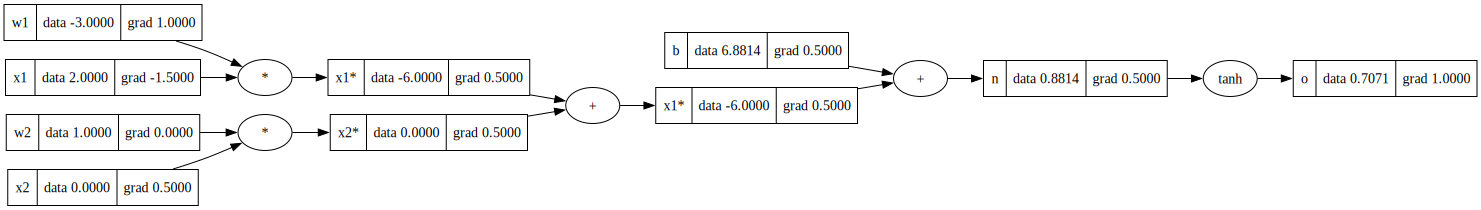

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

tanh manual

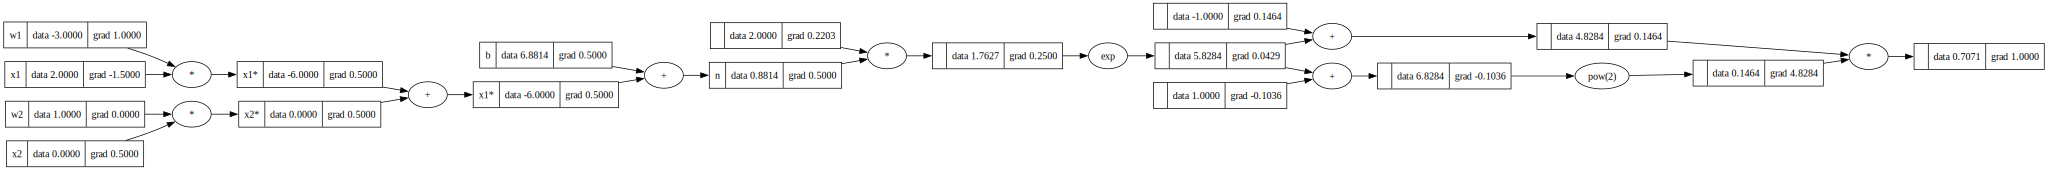

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----- manual tanh ------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----- manual tanh ------
o.backward()
draw_dot(o)

### Neuron and Layer classes

In [12]:
from head2grad import Neuron, Layer, MLP

# Single neuron doing elementwise vector multiplication + bias
x = [2, 3]
n = Neuron(2)
n(x)

Value(data=-0.9917317696727084)

In [13]:
# Layer representing transformation [1, 2] x [2, 3] -> [1, 3]
x = [2, 3]
p = Layer(2, 3)
p(x)

[Value(data=0.5817270619168307),
 Value(data=-0.7878755440086811),
 Value(data=-0.9983781851034336)]

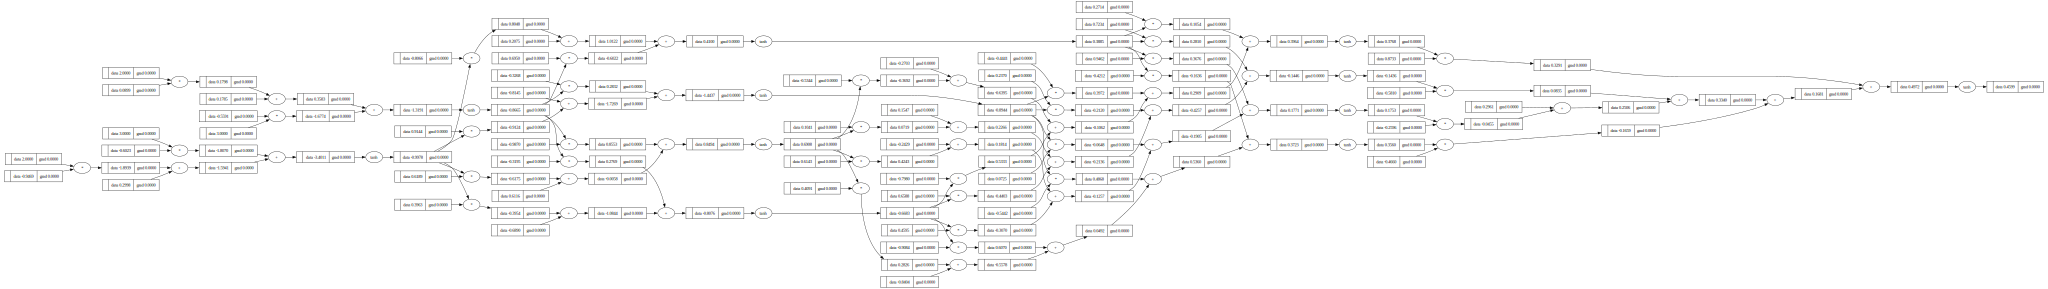

In [14]:
# Whole-ass MLP
# how quickly it built up to ACTUALLY working thing
# is so great I regained the will to live

x = [2, 3]
p = MLP(2, [2, 4, 4, 1])
p(x)

draw_dot(p(x))

### Synthetic dataset and forced convergence

In [15]:
import random 
import matplotlib.pyplot as plt

# think you can change him? hes just ones all day long baby
n = 50
w = 3
ds = zip([[random.randint(-50, 50) for _ in range(w)] for _ in range(n)], [1 for _ in range(n)])
ds = list(ds)

ds[:5]

[([27, 31, -29], 1),
 ([18, 43, -19], 1),
 ([-30, 9, -2], 1),
 ([-16, 31, 38], 1),
 ([21, -22, 37], 1)]

In [16]:
model = MLP(3, [5, 5, 1])
model

LinearLayer(3, 5)
LinearLayer(5, 5)
LinearLayer(5, 1)

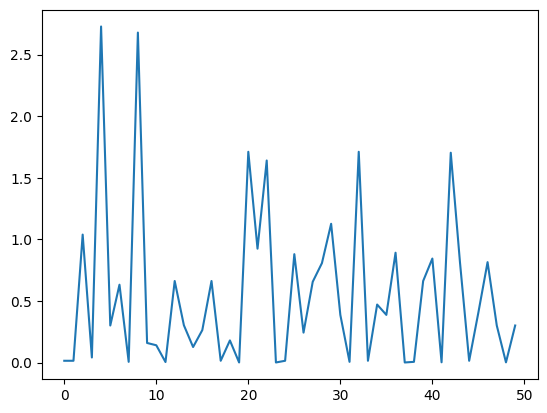

In [17]:
# no optimization, just to see the initial state of the model
losses = []

for x, target in ds:
    y = model(x)
    loss = (y - target) ** 2
    losses.append(loss.data)

plt.plot(losses)

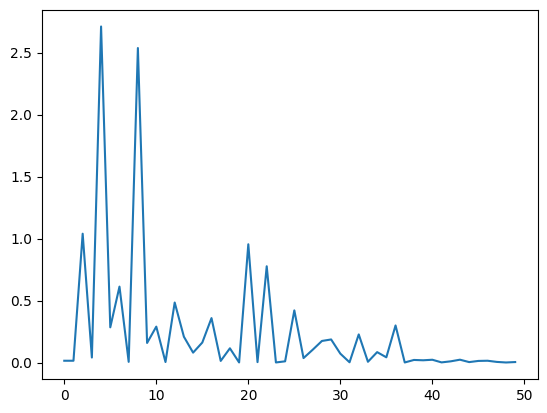

In [18]:
# YOOOOOOOOOOOO IT LIVES
losses = []

for x, target in ds:
    y = model(x)
    loss = (y - target) ** 2
    losses.append(loss.data)

    loss.backward()
    model.step()

plt.plot(losses)

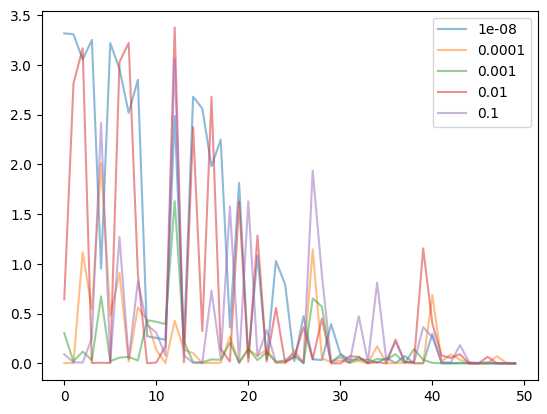

In [19]:
# this turns way harder for nn than I thought
lrs = [0.00000001, 0.0001, 0.001, 0.01, 0.1]
for lr in lrs:
    losses = []
    model = MLP(3, [5, 5, 1])

    for x, target in ds:
        y = model(x)
        loss = (y - target)**2
        losses.append(loss.data)

        loss.backward()
        model.step()

    plt.plot(losses, alpha=0.5)
    plt.legend(lrs)

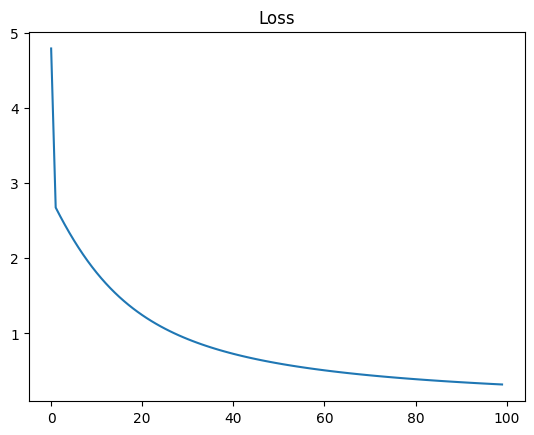

In [20]:
# yoooooo dude we didnt zero_grad, so we accumulated gradients 
# the whole training
# also -> simplified the dataset
n = 5
w = 3
ds = zip([[random.randint(-50, 50) for _ in range(w)] for _ in range(n)], [1 for _ in range(n)])
ds = list(ds)

mlp = MLP(3, [4, 4, 1])

losses = []
for i in range(100):
    ys = [mlp(x) for x, y in ds]
    loss = sum([(y - 1)**2 for y in ys])

    mlp.zero_grad()
    loss.backward()
    mlp.step()

    losses.append(loss.data)

plt.title("Loss")
plt.plot(losses)

In [21]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

n = MLP(3, [4, 4, 1])

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0
    # n.zero_grad()
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 5.2049209675449015
1 2.021299570513203
2 1.199852448576805
3 0.45491337453534714
4 0.06454741454198307
5 0.05324152033579697
6 0.04570878414609903
7 0.04020655838743084
8 0.03595815709343763
9 0.032554098783287536
10 0.0297532079907752
11 0.02740190571251818
12 0.025396608131595326
13 0.023664323894588495
14 0.022151821956609082
15 0.02081919552751002
16 0.019635840857750834
17 0.018577839028084922
18 0.01762619171932981
19 0.016765597527608506


```
0 6.760492834169721
1 3.608048795917721
2 1.5367343176264416
3 0.551363041625893
4 0.17157729936861638
5 0.11857111058237818
6 0.08996681571450539
7 0.07213413561936619
8 0.06000020574980058
9 0.051235783196544246
10 0.044623330877942714
11 0.03946588949773901
12 0.035336476911761804
13 0.03195931153391331
14 0.029148553455606144
15 0.02677453337484821
16 0.02474410050261688
17 0.022988661832417986
18 0.021456621609592136
19 0.020108444763671886
```